# World Happiness Index
#### Oyun Adilbish, Lane Maitland, Jesse Price, Varun Saini
#### <span style="color:purple"> iXperience - Data Science - Purple </span>.
#### July 22, 2021

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-Processing

In [2]:
# read csv files into data frames
df = pd.read_csv("data/world-happiness-report.csv")
df2021 = pd.read_csv("data/world-happiness-report-2021.csv")

Note that we have two data sets. The first contains data from 2008-2020, and the second contains data from 2021. We wish to combine these into one data frame, so we must examine their columns.

In [3]:
# examine names of columns for 2008-2020 data frame
list(df.columns)

['Country name',
 'year',
 'Life Ladder',
 'Log GDP per capita',
 'Social support',
 'Healthy life expectancy at birth',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'Positive affect',
 'Negative affect']

In [4]:
# examine names of columns for 2021 data frame
list(df2021.columns)

['Country name',
 'Regional indicator',
 'Ladder score',
 'Standard error of ladder score',
 'upperwhisker',
 'lowerwhisker',
 'Logged GDP per capita',
 'Social support',
 'Healthy life expectancy',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'Ladder score in Dystopia',
 'Explained by: Log GDP per capita',
 'Explained by: Social support',
 'Explained by: Healthy life expectancy',
 'Explained by: Freedom to make life choices',
 'Explained by: Generosity',
 'Explained by: Perceptions of corruption',
 'Dystopia + residual']

The column names do not match. We will make the following adjustments:
- add a column to the 2021 data frame to store the year
- drop columns whose data will not be analyzed
- rename the columns so that measurements for the same variable from different data sets will land in a single column
- add a column to the 2005-2020 data frame to store the regional indicator

In renaming the columns, we assume that healthy life expectancy at birth is the same as healthy life expectancy.

In [5]:
# add column for year on 2021 data frame
df2021['Year'] = 2021

In [6]:
# drop columns whose data will not be analyzed
df2021 = df2021.drop(columns=['Standard error of ladder score','upperwhisker', 'lowerwhisker',
       'Ladder score in Dystopia',
       'Explained by: Log GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual'], axis=1)
df = df.drop(columns=['Positive affect','Negative affect'], axis=1)

In [7]:
# rename columns
df2021 = df2021.rename(columns = {'Logged GDP per capita':'Log GDP per capita'} )
df = df.rename(columns= {'year':'Year', 'Life Ladder':'Ladder score', 'Healthy life expectancy at birth' : 'Healthy life expectancy'})

To add the regional indicator to the 2005-2020 data frame, we merge this data frame with one that consists of two columns from the 2021 data frame. Specifically, we take only the country and region, and we merge on the country.

In [8]:
# add column for regional indicator on 2005-2020 data frame
df_with_regions = pd.merge(df, df2021[['Country name','Regional indicator']], on = ['Country name'])

We now combine the data frames by using concatination, confirm that we have data from years 2005-2021, and add a column to classify whether the year was pre-COVID or post-COVID. Note that we assume 2005-2019 to be pre-COVID and 2020-2021 to be post-COVID. We then reorder the columns so that columns related to names and dates appear before the others.

In [9]:
# combine data sets to create one data frame for 2005-2021
df_all = pd.concat([df_with_regions, df2021], ignore_index=True).sort_values(by="Country name", ascending=True)
years_list = list(df_all["Year"].unique())
sorted(years_list)

[2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]

In [10]:
# add column for time in terms of COVID
def covid_time(row):
    if row["Year"] < 2020: #distinguishing between pre-covid and post-covid could be improved if we had data by month and if we had data in future
        return "Pre-COVID"  #assuming that the pre-covid is before 2020
    else:
        return "Post-COVID" #assuming that the post-covid is 2020 & 2021

df_all["COVID time"] = df_all.apply(covid_time, axis=1)

In [11]:
# reorder columns
df_all = df_all[['Country name',
                 'Regional indicator',
                 'Year',
                 'COVID time',
                 'Ladder score',
                 'Log GDP per capita',
                 'Healthy life expectancy',
                 'Social support',
                 'Freedom to make life choices',
                 'Generosity',
                 'Perceptions of corruption']]

In [12]:
# confirm that data frame has the necessary columns in the intended order
list(df_all.columns)

['Country name',
 'Regional indicator',
 'Year',
 'COVID time',
 'Ladder score',
 'Log GDP per capita',
 'Healthy life expectancy',
 'Social support',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption']

We define some of these terms below. This information was provided with the data and is further explained [here](https://happiness-report.s3.amazonaws.com/2021/Appendix1WHR2021C2.pdf)
- **ladder score:** measure of happiness
    - *the question is "Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?"*
- **log GDP per capita:** the log of a country's economic output divided by its population, also a factor in standard of living
- **healthy life expectancy:** the number of years of full health that a newborn could expect to live, assuming constant rates of morbidity and mortality
- **freedom to make life choices:** binary measure of freedom
    - *the binary question is "Are you satisfied or dissatisfied with your freedom to choose what you do with your life?"*
- **generosity:** the residual of regressing national average of response to the binary question "Have you donated money to a charity in the past month?" on GDP per capita
- **perceptions of corruption:** average of responses to two binary measures of corruption, considers government and businesses
    - *“the questions are "Is corruption widespread throughout the government or not?" and "Is corruption widespread within businesses or not?"*

The target variable in our analysis is ***ladder score***. We recognize that equating ladder score to happiness is a large assumption, though it is difficult to assign a numeric value to measure happiness.

In [13]:
# observe the head and tail of the processed data frame
df_all

,Country name,Regional indicator,Year,COVID time,Ladder score,Log GDP per capita,Healthy life expectancy,Social support,Freedom to make life choices,Generosity,Perceptions of corruption
0,Afghanistan,South Asia,2008,Pre-COVID,3.724,7.370,50.800,0.451,0.718,0.168,0.882
11,Afghanistan,South Asia,2019,Pre-COVID,2.375,7.697,52.400,0.420,0.394,-0.108,0.924
10,Afghanistan,South Asia,2018,Pre-COVID,2.694,7.692,52.600,0.508,0.374,-0.094,0.928
9,Afghanistan,South Asia,2017,Pre-COVID,2.662,7.697,52.800,0.491,0.427,-0.121,0.954
8,Afghanistan,South Asia,2016,Pre-COVID,4.220,7.697,53.000,0.559,0.523,0.042,0.793
...,...,...,...,...,...,...,...,...,...,...,...
1873,Zimbabwe,Sub-Saharan Africa,2008,Pre-COVID,3.174,7.461,44.140,0.843,0.344,-0.090,0.964
1871,Zimbabwe,Sub-Saharan Africa,2006,Pre-COVID,3.826,7.711,41.580,0.822,0.431,-0.076,0.905
2033,Zimbabwe,Sub-Saharan Africa,2021,Post-COVID,3.145,7.943,56.201,0.750,0.677,-0.047,0.821
1877,Zimbabwe,Sub-Saharan Africa,2012,Pre-COVID,4.955,7.983,49.540,0.896,0.470,-0.103,0.859


In [14]:
# check for missing values
df.isna().sum()

Country name                      0
Year                              0
Ladder score                      0
Log GDP per capita               36
Social support                   13
Healthy life expectancy          55
Freedom to make life choices     32
Generosity                       89
Perceptions of corruption       110
dtype: int64

We chose not to remove rows with missing values because a lot of our analysis relies on averages, and we did not want to shorten our data set.

# Sort Countries by Average Ladder Score (2005-2021)

In [15]:
df_all_ladder = df_all.groupby(['Country name', 'Regional indicator'])['Ladder score'].mean().sort_values(ascending=False)
print("top 15:\n", df_all_ladder.head(15))
print("\nbottom 15:\n", df_all_ladder.tail(15))

top 15:
 Country name   Regional indicator          
Denmark        Western Europe                  7.676625
Finland        Western Europe                  7.614643
Switzerland    Western Europe                  7.550364
Norway         Western Europe                  7.501455
Netherlands    Western Europe                  7.466133
Iceland        Western Europe                  7.458444
Sweden         Western Europe                  7.369063
Canada         North America and ANZ           7.359250
New Zealand    North America and ANZ           7.308067
Australia      North America and ANZ           7.275467
Austria        Western Europe                  7.244071
Israel         Middle East and North Africa    7.214562
Costa Rica     Latin America and Caribbean     7.172000
United States  North America and ANZ           7.081500
Luxembourg     Western Europe                  7.070250
Name: Ladder score, dtype: float64

bottom 15:
 Country name  Regional indicator          
Sierra Leone  Su

We observe that many of the countries in the top/bottom 10 belong to the same region, so we feel that performing an analysis of average ladder score by region will be safe and valid. If the performance of countries in the same region differed greatly, we may wish to proceed with an analysis by country.

# Average Ladder Score by Region

## 2021

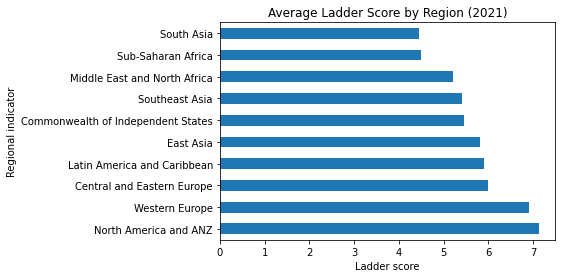

In [16]:
df2021.groupby('Regional indicator')['Ladder score'].mean().sort_values(ascending=False).plot.barh()

plt.xlabel("Ladder score")
plt.title("Average Ladder Score by Region (2021)")
plt.savefig('figures/by_regions_2021.png', dpi=300, bbox_inches='tight')

## 2005-2021

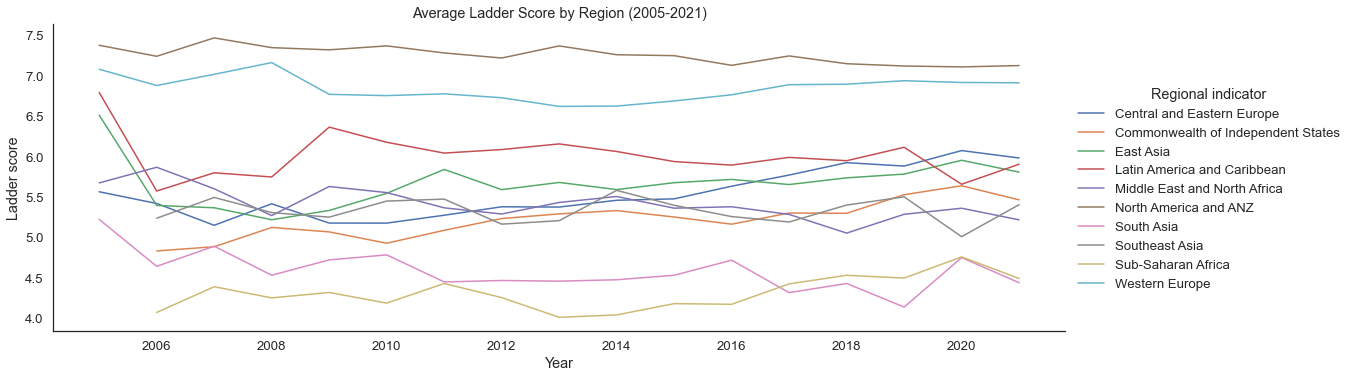

In [17]:
df_region = df_all.groupby(['Regional indicator', 'Year'])['Ladder score'].mean().to_frame().reset_index()
df_pivot_region = df_region.pivot("Year", "Regional indicator", "Ladder score")

sns.set(style="white", font_scale=1.2)
sns.relplot(data=df_pivot_region, kind="line", height=5, aspect=3, dashes=False)

plt.ylabel("Ladder score") 
plt.title("Average Ladder Score by Region (2005-2021)")
plt.savefig("figures/by_region_all.png", dpi=300, bbox_inches='tight')

## Pre-COVID vs. Post-COVID

For our analysis of the impact of COVID, we chose to only examine 2018-2019 as pre-COVID since we only had two years of data for post-COVID. We believed that the ladder score before 2018 was not representative of a country's performance near the start of the pandemic.

We note that our analysis could be improved if we had obtained data by month, as the effects of the coronavirus began earlier (and persisted later) in some countries than others.

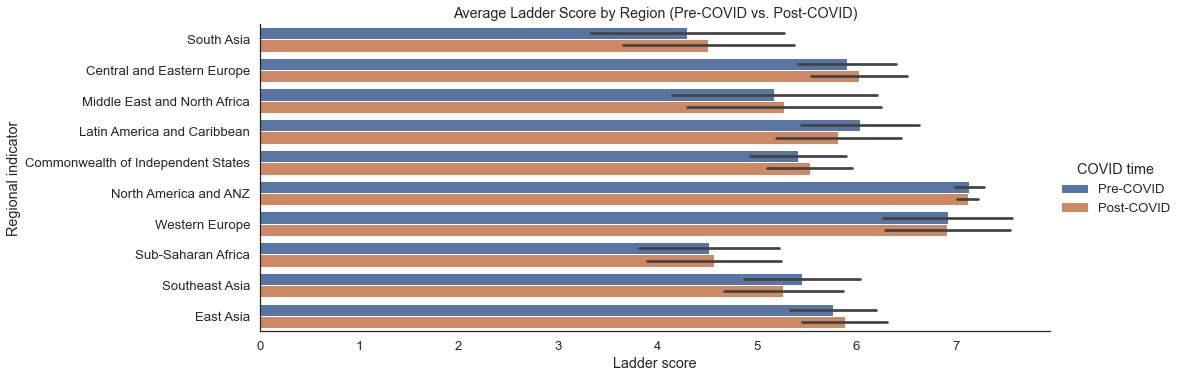

In [18]:
sns.set(style="white", font_scale=1.2)
covid_plot = sns.catplot(x="Ladder score", y="Regional indicator", hue="COVID time", data=df_all[df_all['Year'] >= 2018], kind="bar", height=5, aspect=3, ci="sd")

plt.title("Average Ladder Score by Region (Pre-COVID vs. Post-COVID)")
plt.savefig('figures/covid.png', dpi=300, bbox_inches='tight')

Observe that the blue and orange bars do not differ much in length, and the error bars overlap greatly. For each region, ladder score did not change drastically as a result of COVID.

# Correlation

We now examine how well the ladder score of a country correlates to the features in the data set. In doing so, we aim to explore whether ladder score is influenced by some factors more than others. We also observe how the features are correlated with other.

## Correlation Table

In [19]:
df_all.corr()

,Year,Ladder score,Log GDP per capita,Healthy life expectancy,Social support,Freedom to make life choices,Generosity,Perceptions of corruption
Year,1.000000,0.038226,0.071433,0.166578,-0.004543,0.237245,-0.044313,-0.087272
Ladder score,0.038226,1.000000,0.789687,0.744895,0.710707,0.522491,0.181507,-0.440817
Log GDP per capita,0.071433,0.789687,1.000000,0.847429,0.704224,0.360170,-0.016865,-0.349512
Healthy life expectancy,0.166578,0.744895,0.847429,1.000000,0.615175,0.390519,0.009876,-0.336120
Social support,-0.004543,0.710707,0.704224,0.615175,1.000000,0.417165,0.059964,-0.228886
Freedom to make life choices,0.237245,0.522491,0.360170,0.390519,0.417165,1.000000,0.321830,-0.490298
Generosity,-0.044313,0.181507,-0.016865,0.009876,0.059964,0.321830,1.000000,-0.281714
Perceptions of corruption,-0.087272,-0.440817,-0.349512,-0.336120,-0.228886,-0.490298,-0.281714,1.000000


## Correlation to Ladder Score (in Color)

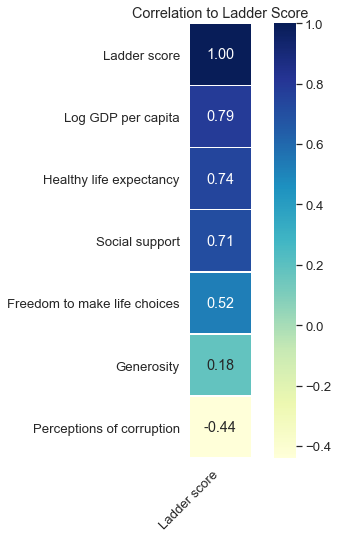

In [20]:
corr_matrix = df_all.drop("Year", axis =1).corr()

f,ax=plt.subplots(figsize=(8,8))
corr_ladder = sns.heatmap(corr_matrix.loc[:, ["Ladder score"]], annot=True, linewidth=.5,fmt='.2f',ax=ax, square=True, cmap='YlGnBu')
corr_ladder.set_xticklabels(corr_ladder.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Correlation to Ladder Score")
plt.savefig('figures/correlation.png', dpi=300, bbox_inches='tight')

Observe that ***perceptions of corruption*** is the only feature with a negative correlation. An increase in any other feature would be expected to raise ladder score, but an increase in perceptions of corruption would be expected to lower ladder score.

## Heat Map

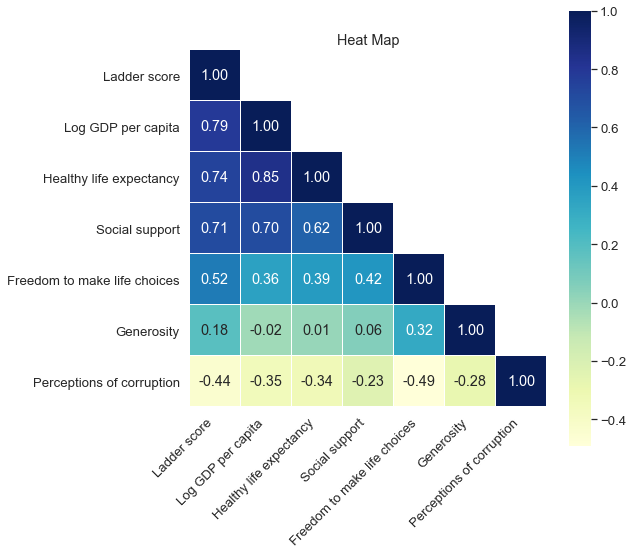

In [21]:
corr_matrix_tri = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(bool))

f,ax=plt.subplots(figsize=(8,8))
hmap = sns.heatmap(corr_matrix_tri, annot=True, linewidth=.5,fmt='.2f',ax=ax, square=True, cmap='YlGnBu')
hmap.set_xticklabels(hmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Heat Map")
plt.savefig('figures/heatmap.png', dpi=300, bbox_inches='tight')

We see that ***log GDP per capita*** and ***healthy life expectancy*** have a strong correlation. They are more closely correlated with each other than either is to ladder score. Although correlation does not imply causation, it may be possible that the values increase or decrease together since a change in either will impact the standard of living and could then result in a change in the other.

# Clustering

In [22]:
# review the columns that have numeric values

list(df_all.select_dtypes(include='number').columns)

['Year',
 'Ladder score',
 'Log GDP per capita',
 'Healthy life expectancy',
 'Social support',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption']

In [23]:
from sklearn import mixture

start = df_all.groupby('Country name').mean()

X = start.select_dtypes(include='number')
X = X[['Ladder score', 'Log GDP per capita', 'Healthy life expectancy', 'Social support', 'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption']].copy()

model = mixture.GaussianMixture(n_components=3, covariance_type='full') 
model.fit(X)
y = model.predict(X)
y = y + 1

# remove the year column because its integer value is irrelevent to correlation with ladder score
to_plot = start.copy().reset_index().drop("Year", axis=1)
to_plot.loc[:, 'cluster'] = pd.Series(y)

## Review Countries in Each Cluster

In [24]:
cluster_sorted = to_plot.sort_values('Country name')

# highest cluster
highest = cluster_sorted.query("`Country name` == 'United States'")['cluster'].iloc[0]

# middle cluster
middle = cluster_sorted.query("`Country name` == 'Russia'")['cluster'].iloc[0]

# lowest cluster
lowest = cluster_sorted.query("`Country name` == 'South Africa'")['cluster'].iloc[0]

print("highest: ", list(cluster_sorted.query('cluster == @highest')['Country name'].unique()))
print("\nmiddle: ", list(cluster_sorted.query('cluster == @middle')['Country name'].unique()))
print("\nlowest: ", list(cluster_sorted.query('cluster == @lowest')['Country name'].unique()))

highest:  ['Australia', 'Austria', 'Belgium', 'Canada', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Hong Kong S.A.R. of China', 'Iceland', 'Ireland', 'Japan', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'North Cyprus', 'Norway', 'Singapore', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']

middle:  ['Albania', 'Algeria', 'Argentina', 'Armenia', 'Azerbaijan', 'Bahrain', 'Belarus', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Greece', 'Guatemala', 'Honduras', 'Hungary', 'Israel', 'Italy', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lebanon', 'Libya', 'Lithuania', 'Malaysia', 'Maldives', 'Mauritius', 'Mexico', 'Moldova', 'Montenegro', 'Nicaragua', 'North Macedonia', 'Palestinian Territories', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia',

## Cluster Breakdown by Regional Indicator

In [25]:
regional = pd.merge(cluster_sorted, df2021[['Country name', 'Regional indicator']], on='Country name')
unstacked = regional.groupby('Regional indicator')['cluster'].value_counts().unstack()
unstacked.rename(columns={highest: 'highest', middle: 'middle', lowest: 'lowest'}, inplace=True)

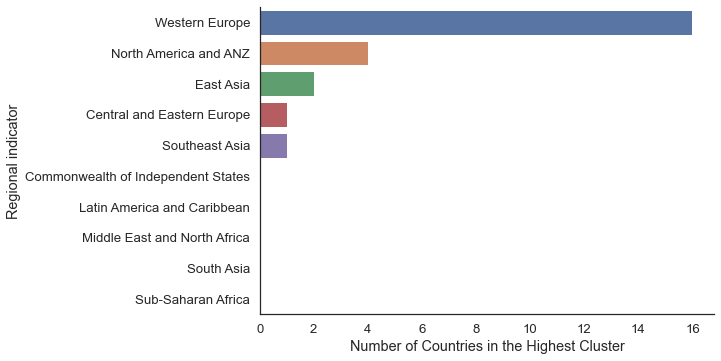

In [26]:
ax_h = sns.catplot(data = unstacked.reset_index().sort_values(by='highest', ascending=False), x='highest', y='Regional indicator', kind='bar', aspect=2)
ax_h.set(xlabel='Number of Countries in the Highest Cluster')

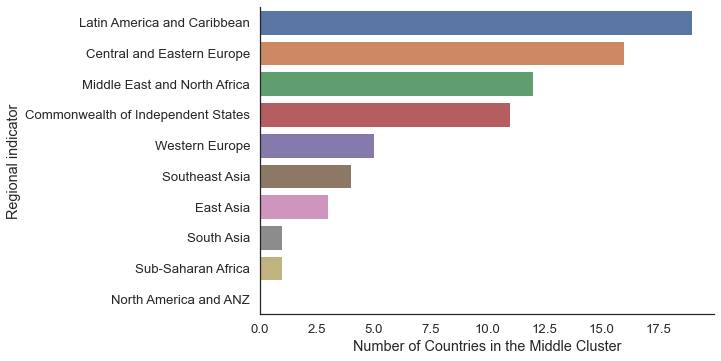

In [27]:
ax_m = sns.catplot(data = unstacked.reset_index().sort_values(by='middle', ascending=False), x='middle', y='Regional indicator', kind='bar', aspect=2)
ax_m.set(xlabel='Number of Countries in the Middle Cluster')

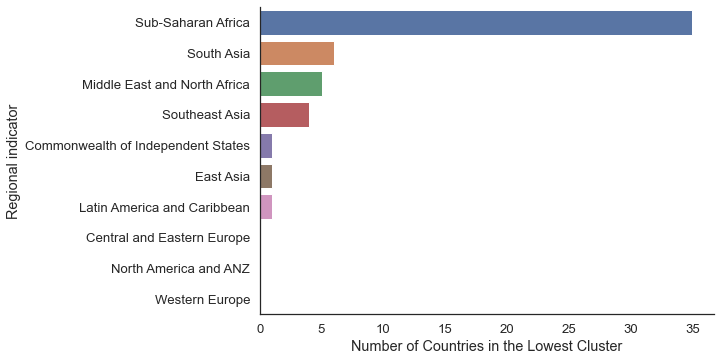

In [28]:
ax_l = sns.catplot(data = unstacked.reset_index().sort_values(by='lowest', ascending=False), x='lowest', y='Regional indicator', kind='bar', aspect=2)
ax_l.set(xlabel='Number of Countries in the Lowest Cluster')

## Pair Plot (Clustered)

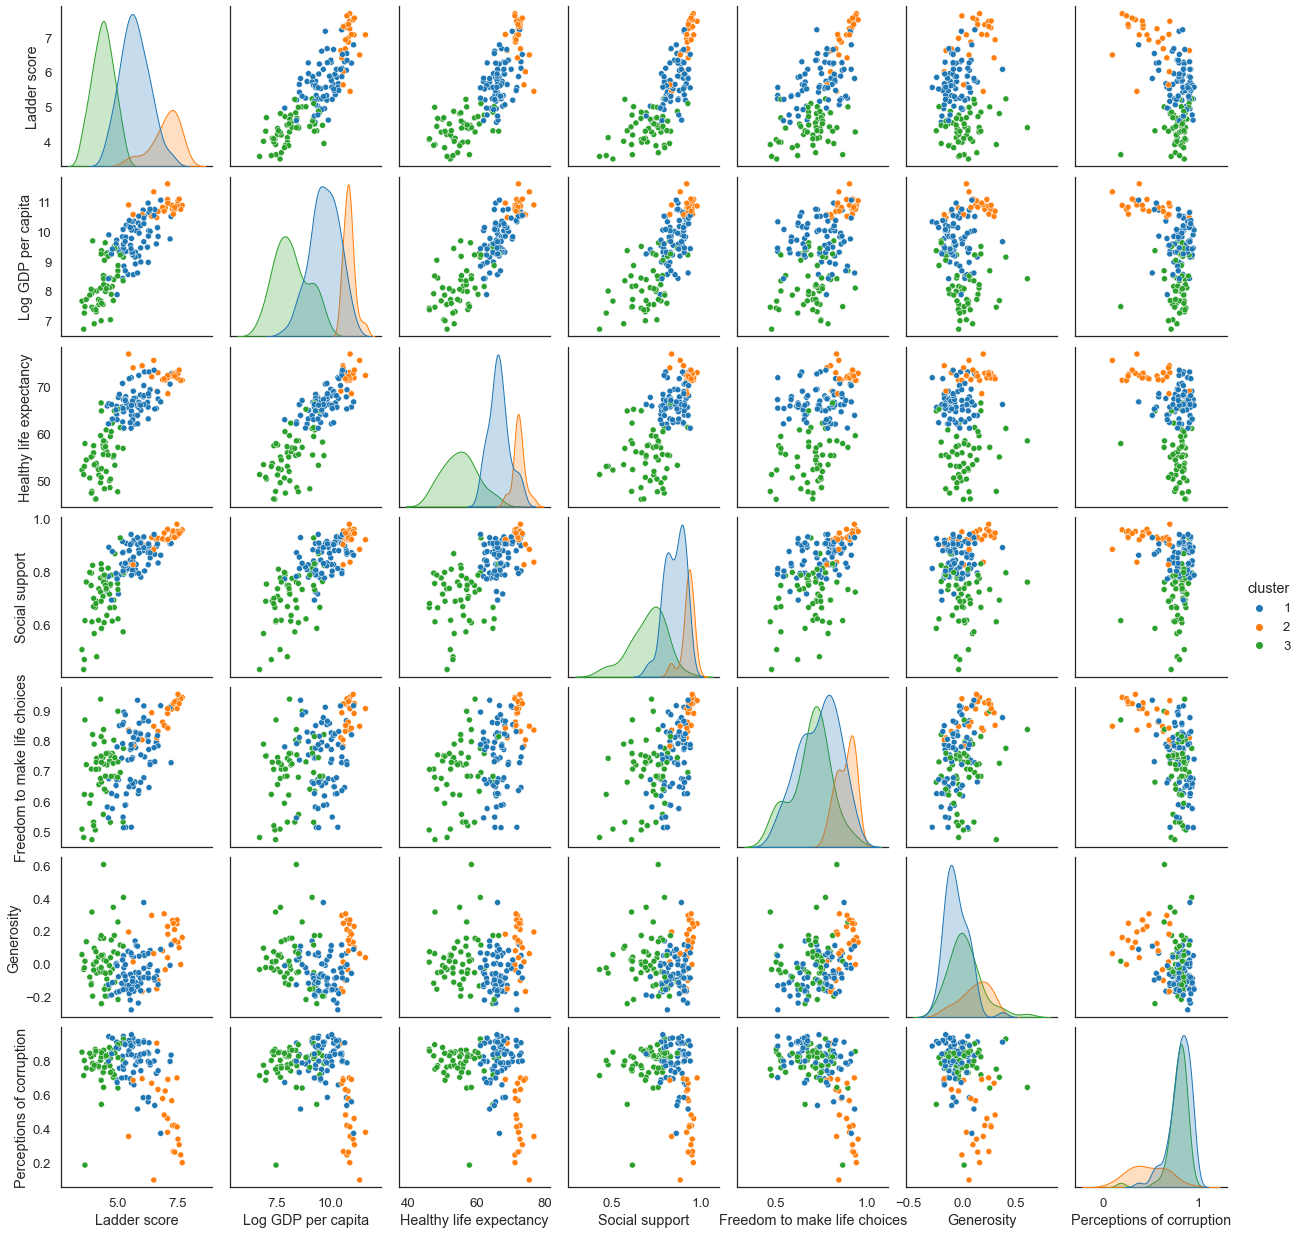

In [29]:
%matplotlib inline
sns.set(style="white", font_scale=1.2)

pair = sns.pairplot(data=to_plot, hue='cluster', palette=sns.color_palette('tab10', n_colors=3))
pair.savefig('figures/pairplot_3clusters.png', dpi=300, bbox_inches='tight')

- The middle cluster is cluster 1 (blue).
- The lowest cluster is cluster 2 (orange).
- The highest cluster is cluster 3 (green).

We see that the clusters are quite well defined (little overlap) in the plots that compare ladder score, log GDP per capita, healthy life expectancy, and social support. These factors strongly influence the standard of living in a country, so it makes sense that the graphs look similar.

## Analysis Using Clusters

### Ladder Score Distribution

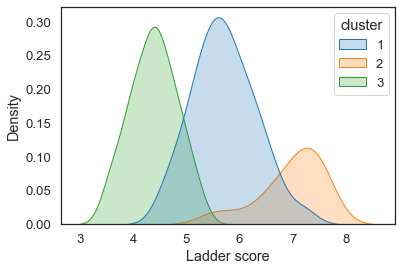

In [30]:
ladder_dist = sns.kdeplot(data=to_plot, shade=True, x='Ladder score', hue='cluster', palette=sns.color_palette('tab10', n_colors=3))
ladder_dist.figure.savefig('figures/ladderdistribution.png', dpi=300, bbox_inches='tight')

### Perceptions of Corruption Distribution

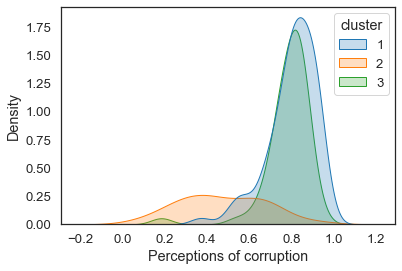

In [31]:
corruption_dist = sns.kdeplot(data=to_plot, shade=True, x='Perceptions of corruption', hue='cluster', palette=sns.color_palette('tab10', n_colors=3))
corruption_dist.figure.savefig('figures/corruptiondistribution.png', dpi=300, bbox_inches='tight')

### Perceptions of corruption vs. Ladder score

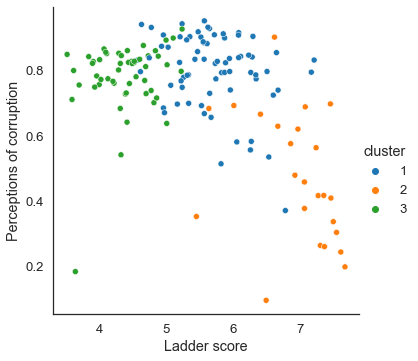

In [32]:
ladder_corruption = sns.relplot(data=to_plot, x='Ladder score', y='Perceptions of corruption', hue='cluster', palette=sns.color_palette('tab10', n_colors=3))
ladder_corruption.savefig('figures/laddervscorruption.png', dpi=300, bbox_inches='tight')

### Perceptions of corruption vs. Log GDP per capita

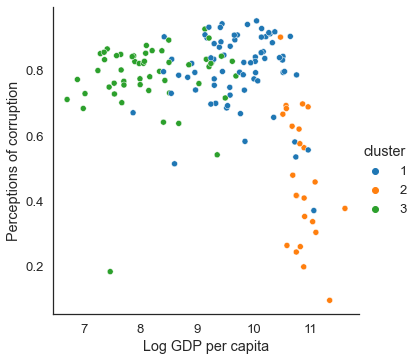

In [33]:
gdp_corruption = sns.relplot(data=to_plot, x='Log GDP per capita', y='Perceptions of corruption', hue='cluster', palette=sns.color_palette('tab10', n_colors=3))
gdp_corruption.savefig('figures/gdpvscorruption.png', dpi=300, bbox_inches='tight')

# Dimensionality Reduction

## 2-Dimensional

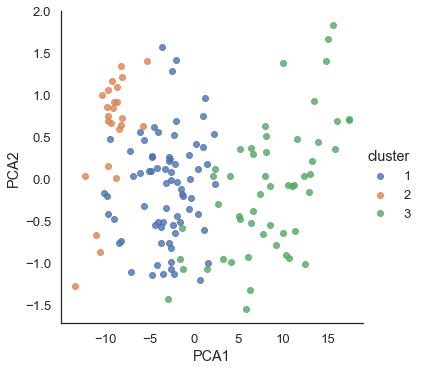

In [34]:
%matplotlib inline
from sklearn.decomposition import PCA
model = PCA(n_components=3)
model.fit(X)
X_2D = model.transform(X)

to_plot['PCA1'] = X_2D[:, 0]
to_plot['PCA2'] = X_2D[:, 1]
to_plot['PCA3'] = X_2D[:, 2]
sns.lmplot(x="PCA1", y="PCA2", hue='cluster', data=to_plot, fit_reg=False);

# Linear Regression

## Different Models for Each Feature

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

feature_list = ["Log GDP per capita", "Healthy life expectancy", "Social support",
                "Freedom to make life choices", "Generosity", "Perceptions of corruption"]

y = to_plot["Ladder score"]

for feature in feature_list:
    model = LinearRegression()
    X = to_plot[[feature]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    print(("{}:\n \t mean squared error: {}\n \t mean absolute error: {}\n \t coefficient of determination: {}")
          .format(feature, mse, mae, r2))

Log GDP per capita:
 	 mean squared error: 0.2987856669750895
 	 mean absolute error: 0.4269022463831896
 	 coefficient of determination: 0.7199246365584022
Healthy life expectancy:
 	 mean squared error: 0.35579254969573354
 	 mean absolute error: 0.5107950015925816
 	 coefficient of determination: 0.6664875906709631
Social support:
 	 mean squared error: 0.37068787017509436
 	 mean absolute error: 0.4825086593470769
 	 coefficient of determination: 0.6525250323626228
Freedom to make life choices:
 	 mean squared error: 0.9593406185771256
 	 mean absolute error: 0.7817097508828256
 	 coefficient of determination: 0.10073439890047697
Generosity:
 	 mean squared error: 1.014165410116749
 	 mean absolute error: 0.8257598938326803
 	 coefficient of determination: 0.04934279912420647
Perceptions of corruption:
 	 mean squared error: 1.1103979472248418
 	 mean absolute error: 0.836249278435469
 	 coefficient of determination: -0.040863545371238263


## One Model with All Features

In [36]:
X = to_plot[["Log GDP per capita", "Healthy life expectancy", "Social support",
                "Freedom to make life choices", "Generosity", "Perceptions of corruption"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [37]:
# model prediction on training data
y_train_pred = model.predict(X_train)

mse = mean_squared_error(y_true=y_train, y_pred=y_train_pred)
mae = mean_absolute_error(y_true=y_train, y_pred=y_train_pred)
r2 = r2_score(y_true=y_train, y_pred=y_train_pred)
print(("mean squared error: {}\nmean absolute error: {}\ncoefficient of determination: {}")
      .format(mse, mae, r2))

mean squared error: 0.19493909899034603
mean absolute error: 0.33616976931804027
coefficient of determination: 0.8240816442121526


In [38]:
# model prediction on testing data
y_test_pred = model.predict(X_test)

mse = mean_squared_error(y_true=y_test, y_pred=y_test_pred)
mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
print(("mean squared error: {}\nmean absolute error: {}\ncoefficient of determination: {}")
      .format(mse, mae, r2))

mean squared error: 0.2201622078139127
mean absolute error: 0.3420739870544459
coefficient of determination: 0.7936246039046876


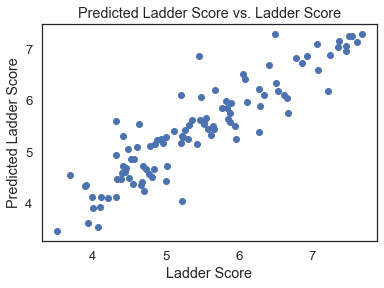

In [39]:
plt.scatter(y_train, y_train_pred)
plt.xlabel("Ladder Score")
plt.ylabel("Predicted Ladder Score")
plt.title("Predicted Ladder Score vs. Ladder Score")
plt.savefig('figures/linreg.png', dpi=300, bbox_inches='tight')
plt.show()

## Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [41]:
# model prediction on testing data
y_test_pred = model.predict(X_test)

mse = mean_squared_error(y_true=y_test, y_pred=y_test_pred)
mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
print(("mean squared error: {}\nmean absolute error: {}\ncoefficient of determination: {}")
      .format(mse, mae, r2))

mean squared error: 0.23051927699382954
mean absolute error: 0.3750347901851231
coefficient of determination: 0.7839161063581944


Observe that the mean squared error, mean absolute error, and coefficient of determination are very similar for the second linear regression model and the random forest regressor model.

In [42]:
importances = pd.DataFrame([X.columns, model.feature_importances_]).T
importances.rename(columns={0: 'Feature', 1: 'Importance'}, inplace=True)

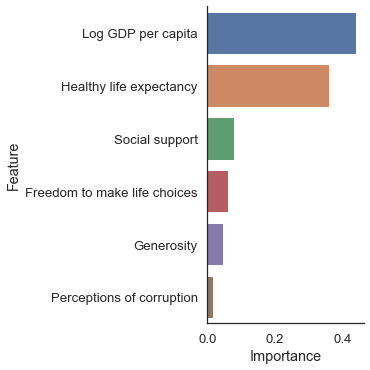

In [43]:
importances_graph = sns.catplot(data=importances.sort_values(by="Importance", ascending=False), x="Importance", y="Feature", kind="bar")
plt.savefig('figures/feature_importances.png', dpi=300, bbox_inches='tight')

From this graph, we see that the value for log GDP per capita plays a very large role in predicting ladder score, though healthy life expectancy and social support are also determining features.

# Pandas Profiling

In [44]:
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# conda update -n base -c defaults conda
# !conda install -c conda-forge pandas-profiling -y

# from pandas_profiling import ProfileReport

In [45]:
# my_report = ProfileReport(df_all, title="World Happiness Index", html={'style':{'full width':True}})
# my_report.to_notebook_iframe()
# my_report.to_file(output_file="World Happiness Index.html")